In [1]:
# only run this cell if you are in collab
!pip install ohmeow-blurr -q
!pip install datasets -q
!pip install bert-score -q

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 1.9MB 11.1MB/s 
     |████████████████████████████████| 14.5MB 252kB/s 
     |████████████████████████████████| 194kB 48.6MB/s 
     |████████████████████████████████| 184kB 55.2MB/s 
     |████████████████████████████████| 1.2MB 47.1MB/s 
     |████████████████████████████████| 4.1MB 43.5MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 890kB 40.8MB/s 
     |████████████████████████████████| 3.2MB 45.2MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 245kB 27.2MB/s 
     |████████████████████████████████| 112kB 59.6MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 


In [2]:
import datasets
import pandas as pd

#!pip install fastai==2.1.8
#!pip install fastcore==1.3.1
from fastai import *
from fastcore import *
from fastai.text.all import *

from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Data Preparation
We're going to use to use the datasets library from huggingface to grab your raw data. This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model. The best part being everything comes down to you in JSON! This makes it a breeze to get up and running quickly!

We'll just use a subset of the training set to build both our training and validation DataLoaders

In [3]:
import os
from google.colab import files

uploaded = files.upload()

import io

  
df = pd.read_csv(io.BytesIO(uploaded['15min_tekstai.csv']), sep='\t')
#df = pd.read_csv('/content/15min_tekstai.csv', sep='\t')

df.head()

Saving 15min_tekstai.csv to 15min_tekstai.csv


,Unnamed: 0,title,text,summary,author,Unnamed: 0.1
0,0,"M.Zingeris: nepasinaudojus žydų bendruomenės potencialu, valstybę atkurti būtų buvę daug sunkiau","Visų pirma verta prisiminti tuos, kurie prie valstybės atkūrimo, o vėliau ir išsaugojimo, prisidėjo tiesiogiai. Tai 1918–1920 metais Nepriklausomybės kovose dalyvavę Lietuvos žydai. Manoma, kad jų buvo apie 3 tūkstančiai, apie 500 — savanoriai. Pasak 15min pašnekovo, šimtai jų, kai kurie jau po mirties, pagerbti ordinais ir medaliais. Kelios dešimtys Lietuvos patriotų žydų apdovanoti Vyčio kryžiaus ordinais.„Prisiminkime Libą Mednikienę iš Širvintų, apdovanotą, kaip tada sakydavo, Vyties (dabar — Vyčio) kryžiaus ordinu už pagalbą Lietuvos kariuomenei ir žvalgybai“, — kalbėjo M.Zingeris.15m...","Valstybę kūrė ne tik etniniai lietuviai, bet ir amžių amžius čia gyvenę žydai litvakai. Anot rašytojo, publicisto Marko Zingerio, to nežinant prieš akis iškyla vienpusis, primityvus, ryškias spalvas praradęs ano meto paveikslas. Vasario 16-oji – puiki proga nuspalvinti tą gerokai išblukusį supratimą.",Aleknavičė Karolina,0.0
1,1,"G.Mažeikis apie tai, kodėl tikime sąmokslo teorijomis ir kaip su jomis kovoti: vos tik uždrausi, iškart išvešės","Sąmokslo teorijos, paaiškino 15min pašnekovas, tai įsivaizdavimas, kad už mūsų nugarų stovi „lėlininkai“, kurie gyvenimus reguliuoja nematomais įrankiais, slaptais susitarimais.„Šios teorijos remiasi priežastiniu mąstymu, įsitikinimu, kad bet kuris įvykis turi konkrečią priežastį ir niekas nekyla spontaniškai. Iš esmės tai neigia laisvės teoriją ir kūrybingumą. Sąmokslo teorijos labai patinka tiems, kurie mėgsta skaičiuoti priežastis“, — svarstė jis ir pridūrė dar vieną įdomų pastebėjimą: sąmokslo teorijos neigia stebuklus, nes stebuklas priklauso spontaniškumo, vadinasi, laisvės sferai. T...","Nors gali atrodyti, kad į baimių pilną sąmokslo teorijų pasaulį pakliūva tik neišsilavinę žmonės, taip nėra. Pasak Vytauto Didžiojo universiteto profesoriaus, Filosofijos ir socialinės kritikos katedros vedėjo Gintauto Mažeikio, tai priklauso nuo to, kiek konkretus asmuo yra linkęs į determinizmą, todėl bet kuris, nepriklausomai nuo išsilavinimo ar politinių pažiūrų, gali įkliūti. O įveikti tai galima ugdant kūrybiškumą ir spontaniškumą – savybes, prieš kurias neatsilaiko jokie sąmokslai.",Aleknavičė Karolina,1.0
2,2,"Istorikas A.Jakubčionis: Lietuva vis tiek būtų tapusi laisva, Sovietų Sąjunga griuvo iš vidaus","Prisimindamas Sausio 13-osios aplinkybes, 15min kalbintas istorikas pabrėžė, kad 1990-ieji buvo laikas, kai laisvės siekiu gyvuojančią Lietuvą Sovietų Sąjunga bandė paveikti įvairiais būdais. Visų pirma, anot jo, visuomenę bandyta įbauginti. Vos paskelbus nepriklausomybę, pasipylė reikalavimai visus aktus nutraukti ir planų atsisakyti, grasinant ekonomine blokada. Griebtasi ir kitų priemonių — pranešta apie karinę prievolę. Galiausiai prasidėjo ekonominė blokada.Pasak A.Jakubčionio, ji išryškino kad Lietuva dar pernelyg integruota į Sovietų Sąjungą ir kad abi yra priklausomos nuo viena kit...","O kas, jeigu ne Sausio 13-oji? Istorikas, Vilniaus universiteto (VU) docentas dr. Algirdas Jakubčionis pastebi, kad net jeigu lemtingą naktį gatvės taip ir būtų likusios tuščios – Lietuva vis tiek būtų tapusi laisva, nes iš vidaus supuvusi Sovietų Sąjunga neturėjo šansų išlikti. Vis dėlto, ne nesuvaldoma istorijos tėkmė, o sąmoningas tautos apsisprendimas atvedė į Sausio 13-ąją. Nors laisvę bandyta slopinti ne tik brutalia jėga, bet ir ekonominėmis priemonėmis bei grasinimais, visuomenė aiškiai parodė — norime gyventi savarankiškoje valstybėje.",Aleknavičė Karolina,2.0
3,3,Dziudo sportininkės mama ir dukra – prieš socialinę atskirtį: ne visi gali sumokėti už vaiko būrelį,"Pasak 15min kalbintos L.Dudėnienės, idėja kovai su socialine atskirtimi pasitelkti dziudo kovos meną subrendo natūraliai.„Mūsų klubą, — prisiminė ji, — dažnai rinkdavosi tie sportininkai ar mažųjų sportininkų tėveliai, kurie neturėjo galimybių mokėti arba jiems kitų klubų siūlomi dziudo tre

In [4]:
df = df[[(len(x) > 30) for x in df.summary]]



We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model). We'll use blurr's get_hf_objects helper method here.


In [5]:
#pretrained_model_name = "facebook/mbart-large-cc25"
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)



Next we need to build out our DataBlock. Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable. That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice that the blurr DataBlock as been dramatically simplified given the shift to on-the-fly batch-time tokenization. All we need is to define a single HF_Seq2SeqBeforeBatchTransform instance, optionally passing a list to any of the tokenization arguments to differentiate the values for the input and summary sequences. In addition to specifying a custom max length for the inputs, we can also do the same for the output sequences ... and with the latest release of blurr, we can even customize the text generation by passing in text_gen_kwargs.

We pass noop as a type transform for our targets because everything is already handled by the batch transform now.


In [6]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'max_length': 142,
 'min_length': 56,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

**PROBLEMS WITH decoder_start_token_id**

In [7]:
#text_gen_kwargs['decoder_start_token_id'] == None

In [8]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs) # reiktu pabandyti pakeisti max_length = 512 ir max_tgt_length = 128

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader('summary'), splitter=RandomSplitter())



In [9]:
import fastai
print(fastai.__version__)

2.2.7


In [10]:
dls = dblock.dataloaders(df, bs=2)

In [11]:
len(dls.train.items), len(dls.valid.items)

(24945, 6236)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [12]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 203]))

Even better, we can take advantage of blurr's TypeDispatched version of show_batch to look at things a bit more intuitively. We pass in the dls via the dataloaders argument so we can access all tokenization/modeling configuration stored in our batch transform above.

In [13]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"Arūnas ir Inga Maldyvuose lankėsi jau antrą kartą. Televizijos laidų prodiuseris ir vedėjas tikina, kad ištisus metus saulėtą kraštą jie vėl pasirinko todėl, kad tai yra kelionė su garantija: „Ir geras oras, ir saulė, ir vanduo. Puikios atostogos.“Paklaustas, kuo visgi Maldyvai yra išskirtiniai, žinant, kad garsi pora turi vilą Kipre, Arūnas paminėjo kelis bruožus, kurie jį labiausiai žavi.„Kipre tuo metu būna vėsoka. Nors tai šilčiausia Viduržemio jūros sala, vis tiek nepalyginsi su Maldy","Kol Lietuvoje spaudžia šaltukas, dažnam norisi pabėgti ten, kur šilta. Tokioms atostogoms neatsispyrė ir viena žinomiausių pramogų pasaulio porų Arūnas ir Inga Valinskai – jie nutarė atsipūsti po pernai nugriaudėjusio Ingos koncertinio turo ir dvi sausio savaites praleido rojaus kampeliu vadinamuose Maldyvuose. Vis dėlto Arūnas neslepia, kad net ir ilsintis egzotiškame krašte visiškai atitrūkti nuo darbų jam nepavyko."
1,"Nieko keista, juk būtent maldos namuose geriausiai atspindima tautos istorija, kurios sunaikinti nepavyko net daugybę šventovių sandėliais ir kitais „viešos paskirties“ pastatais pavertusiems okupantams.Tęsdami projektą #šaliamūsų ir pasakojimą apie Lietuvos žydų (litvakų) bendruomenę, šįkart kviečiame apsilankyti dviejose skirtingose Vilniaus sinagogose. Jos skirtingos ne tik tuo, jog viena – veikianti, o kita – tik dabar pradėta restauruoti.TAIP PAT SKAITYKITE: Pažintis su Lietuvos žydais – beigeliais kvepiančioje krautuvėje","Kai kalbame apie skirtingas tautas, labai dažnai pirmiausia prieš akis iškyla jų maldos namų vaizdinys: musulmonai – mečetė, krikščionys – bažnyčia ir cerkvė, karaimai – kenesa, žydai – sinagoga."


# **Training**
We'll prepare our BART model for training by wrapping it in blurr's HF_BaseModelWrapper object and using the callback, HF_BaseModelCallback, as usual. A new HF_Seq2SeqMetricsCallback object allows us to specify Seq2Seq metrics we want to use, things like rouge and bertscore for tasks like summarization as well as metrics such as meteor, bleu, and sacrebleu for translations tasks. Using huggingface's metrics library is as easy as specifying a metrics configuration such as below.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable. See here for our discriminitative learning rates work in fastai.

**Note**: This has been tested with ALOT of other Seq2Seq models; see the docs for more information.

In [14]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'lt' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [15]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

Still experimenting with how to use fastai's learning rate finder for these kinds of models. If you all have any suggestions or interesting insights to share, please let me know. We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.


SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.7585775852203369)

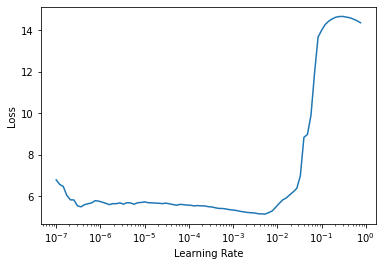

In [16]:
learn.lr_find(suggestions=True)

In [17]:
#a = []
#while(1):
#    a.append('1')

In [18]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(7.3915, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 203, 50264]))

In [19]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time


AttributeError: ignored

In [20]:
learn.show_results(learner=learn, max_n=2)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time


,text,target,prediction
0,"„Strategiškai viskas keisis“, – pareiškė R.Milašius per ilgą pokalbį su žiniasklaida.Dar ketverių metų kadencijai perrinktas LKL prezidentas po ramaus sezono ketina pakelti lygą į aukštesnį lygį.Naujos princesės LKL turbūt neišvysime, tačiau permainos intriguoja.R.Milašius teigiamai atsiliepė apie naują „Lietuvos ryto“ šeimininką Antaną Guogą ir užstojo dėl rasizmo skandalo įklimpusį Gedvydą Vainauską.Vilniaus klubo žingsnis į priekį būtų naudingas ir","LKL administratorė Sigita Belickaitė pašoko nuo viešbučio koridoriaus sofos ir su puokšte rankose įbėgo į visuotinio susirinkimo salę pasveikinti Remigijaus Milašiaus. Moteris žinojo, kad tos gėlės bus skirtos vieninteliam žmogui, kuris dalyvavo neintriguojančiose LKL prezidento lenktynėse.","Lietuvos krepšinio lygos (LKL) prezidentas Ramūnas Milašius pareiškė, kad ketverių metų kadencijai perrinktas ketina pakelti lygą į aukštesnį lygoje, tačiau neišvysime."
1,"Testą sudaro 10 klausimų apie lietuviškus serialus. Visur turėsite teisingai iš keturių variantų pasirinkti, koks tai serialas. Ar pavyks teisingai atsakyti į bent 7-is klausimus iš 10?Testą rasite žemiau. Norėdami pradėti spręsti testą, spauskite „Pradėti“. Sėkmės!Lietuviški serialaiŠiame 2000 m. pradėtame rodyti humoro seriale vaidino Redita Dominaitytė, Regina Varnaitė, Dalius Mertinas, Linas Karalius ir kiti. Serialas vaizdavo šeimos gyvenimą. Kaip vadinosi serialas?Šio serialo pagrindinis veikėjas – jaunas ūkininkas, vardu Pijus. Vienas Liet","Ar esate geras lietuviškų televizijos serialų žinovas? Portalas 15min sukūrė testą, kuris padės tai išsiaiškinti.","Lietuviški serialas „Pradėti“, kurioje šeštadienio vakarą sukėlė testą, kuriame sudaro 10 klausimų apie serialą."


In [60]:
test_article = """Susitelkti teko visiems Praeitos savaitės pabaigoje progimnazijos Tėvų tarybos pirmininkas Arūnas Penkaitis sakė, kad grįžimo į mokyklą laukiama kaip šventės, kaip gimtadienio: „Anksčiau, kai išties turėjome tam tikrą informacijos trūkumą, nuotaikų buvo įvairių. Šiuo metu, gavus atsakymus į visus kilusius klausimus, didžioji dauguma bendruomenės nusiteikusi labai pozityviai.“ Mokyklos direktorius R.Remeika praėjusią savaitę 15min teigė, kad nuotolinis ugdymas nėra toks efektyvus, todėl siekiama kuo greičiau pereiti į kontaktinį mokymą. Pirmadienio rytą jis feisbuke džiaugėsi, kad bendruomenė susitelkė ir atsakingai dirbdama parodė, kiek daug vaikų labui gali padaryti. O ši savaitė taip pat būsianti susitelkimo metas, kai teks griežtai laikytis visų saugumo taisyklių tiek mokykloje, tiek namuose, tiek viešoje erdvėje, nes esą nėra „prabangos“ susirgti ir taip rizikuoti aplinkinių sveikata. Rezultatus vertins po dar vienų testų Anot Vilniaus mero Remigijaus Šimašiaus, prieš grįžtant į klases buvo testuojami ir darbuotojai, ir mokiniai, ir jų šeimų nariai, tad iššūkių netrūko. „Savaitės pabaigoje vėl bus atliekami testai, žiūrėsime, kokie rezultatai. Nes patys suprantame, kad švietimas yra ta sritis, kur labai norisi grįžti į normalias vėžes ir dar geresnes – per pandemiją išmoko naujų dalykų ir mokytojai, ir mokiniai. Kartu suprantame tą riziką – iš Estijos gavome ataskaitą, kad mokyklose didelė rizika, vaikai vieni kitiems perneša. Mūsų tą eksperimentą Lietuvos mastu traktuoju kaip labai svarbų – kaip organizuoti ir kaip paskui viskas vyks“, – kalbėjo R.Šimašius. Mero teigimu, jeigu reikėtų pagal tokią pačią procedūrą atidaryti visas Lietuvos ar Vilniaus mokyklas, tai greičiausia nebūtų įmanoma – resursų niekam ir niekada neužtektų. Todėl reikia apibendrinti išvadas, kaip tai galima padaryti paprasčiau. Apie tai ketinama diskutuoti ir su Vyriausybe. Atsidarytų nors rytoj Paklaustas, kada galėtų visos mokyklos atsidaryti, meras sakė, kad jeigu virusas iš Lietuvos išeitų, tai galima būtų ir rytoj padaryti. „Bet kada jis išeis, kokiu tempu, kokios variacijos, kiti dalykai, negaliu pasakyti. Bet jeigu epidemiologinė situacija leistų, sugrįžti į mokyklas mums nebūtų problemų. Nebent kiltų vienai kitai šeimai, nes ne paslaptis, kad ne vienas moksleivis, kartais ir mokytojai pamokose dalyvauja ne iš Vilniaus, kartais net ir į užsienį išvažiavę“, – sakė R.Šimašius. Jis įsitikinęs, kad tokių ar panašių eksperimentų turėtų būti ir daugiau, tai leistų lengviau grįžti visiems, kai epidemiologinė situacija leis. Vilnius rengė konferenciją su mokytojais, svarstė nuotolinio mokymosi sąlygas ir būdus, tai joje paaiškėjo, kad tiek abiturientai, tiek mokytojai vieningai sako, kad egzaminų vėlinti negalima ir nereikia, yra pasiūlymų, kaip organizuoti juos tinkamai įprastu metu. Buvo teigiamų testų Vilniaus visuomenės sveikatos biuro vadovė Guoda Ropaitė-Beigė teigė, kad viso šio proceso metu mokyklos bendruomenė buvo itin aktyvi: „Ketvirtadienį startavome su pedagogų testavimu kaupinių principu, tai 93 asmenys, sudarėme 39 kaupinius, visi buvo neigiami. Tai tikrai mokytojai saugūs ir sveiki grįžo į šitą įstaigą. O kalbant apie namų ūkius – t. y. vaikus ir jų tėvelius, testavimas vyko penktadienį, šeštadienį ir dar sudarėme galimybę ir sekmadienį testuotis. Buvo per 500 kaupinių, daugiau nei 2 tūkst. asmenų atvyko testuotis į testavimo punktą, keturi kaupiniai buvo teigiami, dabar vykdomi tyrimai PGR tyrimai.“ Šis testavimo būdas skiriasi nuo PGR tuo, kad pastarojo atveju imamas mėginys iš nosiaryklės ir ryklės, o kaupinio – iš nosies landų ir tie ėminiai grupuojami: vienoje virusologinėje terpėje grupuojami ir dedami kelių asmenų ėminius ir jie tiriami. Jeigu gaunamas teigiamas rezultatas, tuomet jau tiems asmenims atliekami PGR testai. Bandomojo projekto laikas – dvi savaitės, pirmoji jau praėjo, antroji yra ši, tad jai baigiantis, penktadienį, planuojamas vizitas į mokyklą, ten bus tiriamos klasės, mėginama pasižiūrėti, kokia situacija savaitę pasimokius kontaktiniu būdu. Jeigu Vyriausybė priims sprendimus, tada bus mokomasi ir kitą savaitę. Šią savaitę Vilnius turėtų gauti 11 tūkst. vakcinų nuo COVID-19, tai džiugina, anot mero, tačiau kiekis vis dar yra per mažas, kad galima būtų sakyti, jog vakcina buvo įveikta pandemija."""

In [68]:
outputs = learn.blurr_generate(test_article, 
                               early_stopping=True, num_beams=5, do_sample=True, 
                               max_length=130, 
                               top_k=50, 
                               top_p=0.95,
                               num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Trečiadienio vakarą Panevėžyje, Tėvų tarybos pirmininkas Arūnas Penkaitis sakė, kad grįžimo į mokyklą laukiama kaip šventės, kaip gimtadienį sukėlė „Anksčiau, kai išties turėjome tam tikrą informacijos trūkumą�

=== Prediction 2 ===
 Trečiadienio vakarą Panevėžyje, Tėvų tarybos pirmininkas Arūnas Penkaitis sakė, kad grįžimo į mokyklą laukiama kaip šventės, praėjusią savaitę sukėlė nuotaikų buvo įvairių mokyklos direktorius Raimundas Remigijaus Š

=== Prediction 3 ===
 Trečiadienio vakarą Panevėžyje, Tėvų tarybos pirmininkas Arūnas Penkaitis sakė, kad dauguma bendruomenės nusiteikusi labai pozityviai, tačiau nuotaikų buvo įvairių. Šiuo metu gavus atsakymus į visus kilusius klausimus, didžioji daugumą



## Save

In [23]:
learn.metrics = None
learn.export(fname='ft_cnndm_export.pkl')

## Load

In [ ]:

inf_learn = load_learner(fname='ft_cnndm_export.pkl')
inf_learn.blurr_generate(test_article)

## Generate summary

In [72]:



test_2 = """Statistikos departamentas skelbia, kad per parą Lietuvoje patvirtinti 243 nauji koronaviruso atvejai. Nuo COVID-19 mirė 7 žmonės.
Per parą mirė 7 asmenys, po vieną priklausė 60–69, 70–79 ir 90–99 metų amžiaus grupėms. 4 asmenys priklausė 80–89 metų amžiaus grupei.
Pastarųjų 14 dienų sergamumas koronavirusine infekcija 100 tūkst. gyventojų siekia 251,4 atvejo. Šis rodiklis dar labiau suprastėjo, lyginant su sekmadienio statistika, tada jis buvo 250,3.
Per praėjusią parą izoliuoti 831 didelės rizikos sąlytį turėję asmenys, iš viso izoliacijoje, įskaitant žmones, kuriems patvirtinta COVID-19 liga, šiuo metu yra 59 002 asmenys.
Atvejų, kai asmenų užsikrėtimo aplinkybės nėra aiškios, t. y. epidemiologinių tyrimų metu nustatyta, jog asmenys išvykę į užsienį nebuvo, su patvirtintais COVID-19 atvejais nebendravo, šiuo metu registruota 28. Atkreiptinas dėmesys, kad šie asmenys epidemiologinės diagnostikos metu įvardija įvairias vietas, t. y. parduotuves, degalines, plovyklas, kur lankėsi, tačiau nurodo, jog kontakto laikas trumpas, o kitų asmenų užsikrėtimo atvejai tose vietose nėra registruoti.
Atvejai, fiksuoti protrūkiuose
Su Marijampolės meno mokykla iš viso siejami 3 koronavirusinės infekcijos atvejai, iš kurių 1 yra antrinis. Per vakar parą buvo patvirtinti 2 atvejai, iš kurių 1 yra antrinis atvejis.
Per savaitgalį Šiaulių apskrityje registruoti 2 nauji židiniai. Vienas susijęs su kailinių gaminių siuvykla Šiaulių mieste, kur registruoti 2 atvejai, kitas – su Joniškio rajone įsikūrusio paukštyno židiniu, kur registruoti 3 atvejai židinyje.
Telšių rajono medienos apdirbimo įmonėje toliau registruojami susirgimai. Per vakar parą užregistruotas 1 COVID-19 ligos atvejis. Iš viso patvirtinti 13 COVID-19 ligos atvejų.
Naujas protrūkis Kauno apskrityje pastaruoju metu patvirtintas baldų gamybos fabrike Kaune, kur nustatyti 3 koronavisrusinės infekcijos atvejai.
Tęsiasi protrūkis žuvies perdirbimo įmonėje Raseinių rajone. Iš viso registruoti 26 atvejai, iš kurių patvirtinti 2 antriniai.
Su Kauno Montesori mokykla–darželiu „Žiburėliu“ iš viso siejami 3 atvejai, iš kurių 1 yra antrinis.
Su duonos kepyklos, įsikūrusios Jonavos rajone, protrūkiu iš viso siejami 5 atvejai, iš kurių 1 patvirtintas antrinis.
Kauno rajono Garliavos lopšelyje–darželyje „Obelėlė“ iš registruoti 7 atvejai.
Kauno menų darželyje „Etiudas“. Iš viso registruoti 5 atvejai, iš kurių 1 patvirtintas antrinis.
Kauno futbolo akademijos protrūkyje iš viso registruota 12 atvejų, iš kurių 2 atvejai yra antriniai.
Per vakar parą 1 pirminis ir 1 antrinis atvejai užfiksuoti, susiję su laivų statybos įmone, įsikūrusioje Klaipėdoje. Su protrūkiu iš viso siejama 27 susirgimai.
Vakar nustatytas 1 atvejis, susijęs su betono ir gelžbetonio gamybos įmone, įsikūrusioje Klaipėdoje. Su protrūkiu iš viso siejama 10 susirgimų.
Naujas protrūkis nustatytas Alytaus lopšelyje–darželyje „Boružėlė“, COVID-19 liga patvirtinta 2 darbuotojoms.
Taip pat naujas protrūkis nustatytas porolono ruošinių gamyba užsiimančioje įmonėje, įsikūrusioje Alytaus rajone. COVID-19 liga patvirtinta 2 darbuotojams.
Tęsiasi protrūkiai vandens tiekimo ir nuotekų tvarkymo įmonėje, įsikūrusioje Alytuje, taip pat VSAT Kabelių užkardoje.
Atvejų, susijusių su protrūkiais šeimose, praėjusią parą visoje Lietuvoje, šiuo metu turimais duomenimis, registruota 22.
Statistika:
Paskutinių 7 d. naujų atvejų vidurkis parai – 520;
199397 – iš viso buvusių/esamų atvejų skaičius (iš jų laboratoriškai patvirtintų: 193354);
7645 – statistinis šiuo metu sergančių asmenų skaičius (deklaruotas: 53472);
184848 – statistinis gyvų pasveikusių asmenų skaičius (deklaruotas: 139021);
746 – per parą epidemiologiškai ištirtų atvejų skaičius;
831 – per parą dėl rizikingo sąlyčio izoliuotų asmenų skaičius;
3328– per parą izoliuotų atvykusių asmenų skaičius;
29120 – bendras saviizoliacijoje esančių asmenų skaičius;
382 – per praėjusią parą vakcinuota pirma skiepo doze;
164089 – iš viso vakcinuota pirma skiepo doze;
73103 – iš viso vakcinuota dviem skiepo dozėmis.
Per paskutinė parą atlikta 6641 PGR tyrimas, 102 antigeno ir 28 atikūnų tyrimai.
Lietuvos ligoninėse šiuo metu gydoma 970 COVID-19 pacientų, 82 iš jų – reanimacijoje, pirmadienį pranešė Statistikos departamentas.
Deguonis papildomai tiekiamas 832 ligoniams, 47 pacientams taikoma dirbtinė plaučių ventiliacija.
Per parą į ligonines dėl COVID-19 paguldyti 58 žmonės.
Iš viso Lietuvoje nuo pandemijos pradžios COVID-19 susirgo 199 tūkst. 398 žmonės.
Pagal deklaruojamus duomenis, tebeserga 53 tūkst. 473 užsikrėtusieji, tačiau statistiškai skaičiuojama, kad sirgti turėtų gerokai mažiau – 7646 asmenys.

"""

In [74]:
learn.blurr_generate(test_article)

[' Vilniaus miesto savivaldybės mokyklos direktorius Raimundas Remeika teigia, kad nuotolinis ugdymas nėra toks efektyvus, todėl siekiama kuo greičiau pereiti į kontaktinį mokymą, kurioje dauguma bendruomenė susitelkė ir atsakingai dirbdama parodė, kiek daug vaikų labui gali padaryti.']